# Selections @ Event-level

This notebook executes the selection workflow for detector datasets, using trigger 2, and simulations.
<br>
The process involves...

In [1]:
import sys
sys.path.append('/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/libs')

import crudo
import fit_functions as ff
from   iminuit import Minuit
from   iminuit.cost import LeastSquares
from   invisible_cities.reco.corrections import read_maps
from   invisible_cities.reco.corrections import apply_all_correction
from   invisible_cities.types.symbols    import NormStrategy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotting_tools as pt
import tables as tb
from   scipy import integrate
from   scipy.optimize import curve_fit
from   scipy.stats    import linregress

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Preliminary

In [2]:
# Directory with the HDF5 files
h5_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/h5/'

# Path files
data_path = os.path.join(h5_dir, 'Data_event_background.h5')
mc_path   = os.path.join(h5_dir, 'MC_event_background.h5')

# Main keys
data_key = '/Data/Events'
mc_key   = '/MC/Events'

We will categorize the selected dataframe into interest regions of the detector.
<br>
In the simulation we have only background (_Electron_ for consistency).

In [3]:
# Store the selected data here!
selected_data_df = {
                        'Run_time': None,  # Corrected run time
                        'Electron': {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}
                   }

selected_mc_df   = {
                        'Run_time': 315360000,  # Simulated exposure (10 years) 
                        'Electron': {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}
                   }

## Data

In [4]:
# List of the low-background runs
runs_info = {
                # Condition: castle = closed & RAS = on #
                # Jun 2025
                15502: {"duration": 85477, "OK": 28287, "LOST": 9564  , "proc_eff": 1.0   },
                15504: {"duration": 85194, "OK": 28297, "LOST": 9537  , "proc_eff": 0.9999},
                15505: {"duration": 86517, "OK": 28632, "LOST": 9725  , "proc_eff": 0.9999},
                15506: {"duration": 84841, "OK": 28438, "LOST": 9603  , "proc_eff": 0.9999},
                15507: {"duration": 55740, "OK": 18569, "LOST": 6149  , "proc_eff": 0.9999},
                15514: {"duration": 59207, "OK": 20054, "LOST": 6646  , "proc_eff": 0.9999},
                15519: {"duration": 34045, "OK": 11420, "LOST": 3646  , "proc_eff": 0.9998},
                15520: {"duration": 85170, "OK": 28050, "LOST": 9130  , "proc_eff": 1.0   },
                15521: {"duration": 85388, "OK": 28396, "LOST": 8831  , "proc_eff": 1.0   },
                15527: {"duration": 69725, "OK": 23560, "LOST": 7411  , "proc_eff": 1.0   },
                15528: {"duration": 41361, "OK": 13460, "LOST": 4426  , "proc_eff": 1.0   },
                15535: {"duration": 84904, "OK": 28799, "LOST": 9156  , "proc_eff": 0.9998},
                15539: {"duration": 56567, "OK": 15618, "LOST": 9586  , "proc_eff": 0.9997}, 
                15540: {"duration": 67663, "OK": 22526, "LOST": 7066  , "proc_eff": 0.9993},
                15541: {"duration": 86630, "OK": 29124, "LOST": 9333  , "proc_eff": 1.0   },
                15542: {"duration": 87915, "OK": 29717, "LOST": 9274  , "proc_eff": 1.0   },
                15543: {"duration": 86570, "OK": 29160, "LOST": 9123  , "proc_eff": 1.0   },
                15544: {"duration": 86566, "OK": 29498, "LOST": 9029  , "proc_eff": 1.0   },
                15545: {"duration": 85892, "OK": 29437, "LOST": 8877  , "proc_eff": 1.0   },
                15546: {"duration": 84822, "OK": 28663, "LOST": 8704  , "proc_eff": 1.0   },
                15547: {"duration": 71594, "OK": 24549, "LOST": 7421  , "proc_eff": 1.0   },
                15557: {"duration": 66088, "OK": 22273, "LOST": 6929  , "proc_eff": 1.0   },
            }

#### Merged Information

In [5]:
# ----- Dataframe ----- #
Data_df = pd.read_hdf(data_path, key=data_key)

Hey! para Data utilizamos únicamente _global_event_!

In [6]:
# Un evento original es un evento en Data_df sí y solo sí NO coinciden event o Run con la fila de abajo (shift)
Data_event_OG = (Data_df[['event', 'Run']] != Data_df[['event', 'Run']].shift())
# Si en event_OG hay un True, significa que es un evento original
Data_is_new_event_block = Data_event_OG.any(axis=1)
# `cumsum()` sobre esta máscara booleana crea un ID único para cada bloque contiguo de hits que pertenecen al mismo evento original
Data_unique_block_id = Data_is_new_event_block.cumsum()

# Con factorize le damos un código identificador a cada bloque de eventos originales
Data_df['global_event'] = pd.factorize(Data_unique_block_id)[0]

In [7]:
# ----- DAQ Time ----- #
DAQ_time = 0.0

# ----- Run Loop ----- #
for run_id, entry in runs_info.items():

    # Run information
    run_long = entry["duration"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]

    # DAQe efficiency + error
    DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
    # print(f'Run {run_id}: DAQeff = {DAQe_CV:.4f} ± {DAQe_error:.4f}')

    # DAQe corrected time
    DAQ_time += run_long * DAQe_CV

# Store the DAQ time
selected_data_df['Run_time'] = DAQ_time

In [103]:
selected_data_df

{'Run_time': 1233555.3809135926,
 'Electron': {'All':          event  npeak           X           Y            Z        Ec  \
  1         9864     35   95.633168 -438.681014   681.764425  0.542706   
  4        27504     27   15.188418  458.268584    55.796634  0.571271   
  5        29226     10  287.090271 -334.220616   200.428283  0.651591   
  7        60621      0   83.578115  431.273517  1188.086513  2.730169   
  8        77540     22  324.533540   47.492359   236.485496  3.058921   
  ...        ...    ...         ...         ...          ...       ...   
  62562  1933827     14 -263.514331  121.883003  1168.113324  0.793794   
  62563  1942416     27 -306.541530  261.138365   361.981124  0.731718   
  62564  1961862     21  388.218263 -181.257126   242.330936  0.668717   
  62569  1976317     13  114.301261 -166.649461   393.095794  0.553185   
  62570  1977941     23  -48.854711 -439.873676   244.847946  0.836512   
  
               Z_min        Z_max       R_max  nS1  nS2  

## Simulation

In [8]:
MC_df = pd.read_hdf(mc_path, key=mc_key)

Hey! para MC utilizamos únicamente _global_event_!

In [9]:
# Un evento original es un evento en MC_df sí y solo sí NO coinciden event o Isotope o Volume con la fila de abajo (shift)
MC_event_OG = (MC_df[['event', 'Isotope', 'Volume']] != MC_df[['event', 'Isotope', 'Volume']].shift())
# Si en event_OG hay un True, significa que es un evento original
MC_is_new_event_block = MC_event_OG.any(axis=1)
# `cumsum()` sobre esta máscara booleana crea un ID único para cada bloque contiguo de hits que pertenecen al mismo evento original
MC_unique_block_id = MC_is_new_event_block.cumsum()

# Con factorize le damos un código identificador a cada bloque de eventos originales
MC_df['global_event'] = pd.factorize(MC_unique_block_id)[0]

# Pre-Selection

### Testing Zone

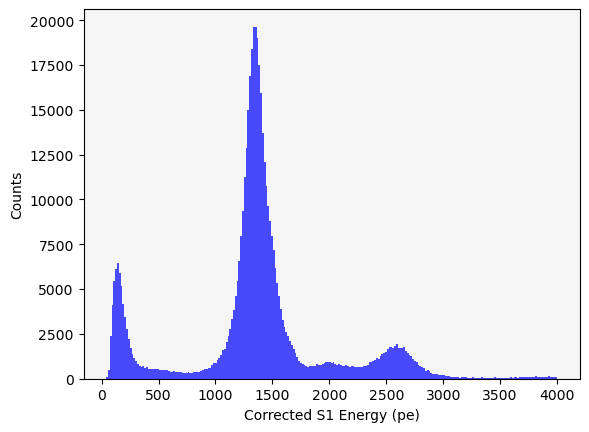

In [73]:
# Global
n_bins = 250
H1_max = 500; E1_max  = 4e3

# Variables
E1 = Data_df['S1e']

E1_bins = np.linspace(E1.min(), E1_max, n_bins)

plt.hist(E1, bins=E1_bins, color='blue', alpha=0.7)
plt.xlabel('Corrected S1 Energy (pe)')
plt.ylabel('Counts')

plt.gca().set_facecolor("whitesmoke")
plt.show()

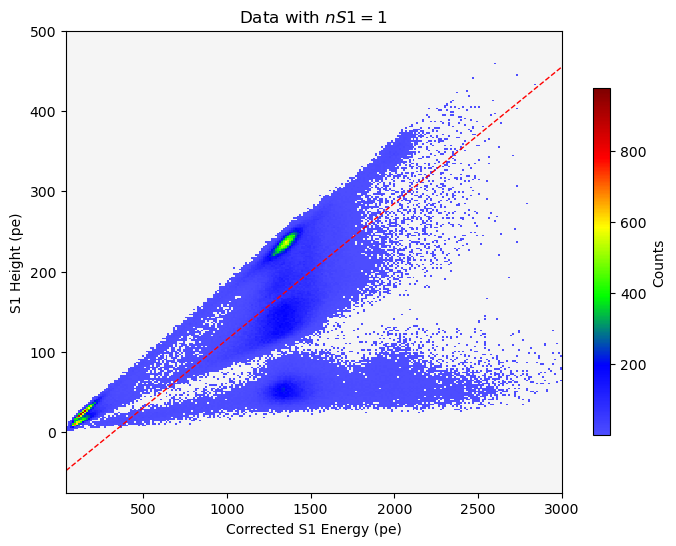

In [46]:
# Global
n_bins = 250
H1_max = 500; E1_max  = 3e3

# Limit line parameters: from selecting_criteria.ipynb
m = 0.17
b = -55

# Masked dataframe
# mask_df = Data_df.copy()
mask_df = Data_df[(Data_df['nS1'] == 1) & (Data_df['nS2'] == 1)]      # Only one S1

# Variables
H1 = mask_df['S1h']
E1 = mask_df['S1e']

# Binning
H1_bins = np.linspace(H1.min(), H1_max, n_bins)
E1_bins = np.linspace(E1.min(), E1_max, n_bins)

# 2D histogram: normalized by corrected DAQ data taking time
S1h_S1e_map, ex, ey = np.histogram2d(E1, H1, bins=[E1_bins, H1_bins])
S1h_S1e_map         = np.ma.masked_where(S1h_S1e_map==0, S1h_S1e_map)     # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.pcolormesh(ex, ey, S1h_S1e_map.T, cmap=pt.custom_hsv, shading='auto')
plt.plot(E1_bins, ff.linear_func(E1_bins, m, b), c='red', ls='--', lw=1)        # Limit line

# ----- Styling ----- #
cbar = plt.colorbar(label='Counts', shrink=0.75)
# cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('Corrected S1 Energy (pe)')
plt.ylabel('S1 Height (pe)')
plt.title(r'Data with $nS1 = 1$')

plt.gca().set_facecolor("whitesmoke")
plt.show()

In [39]:
mask_df

,event,npeak,X,Y,Z,Ec,Z_min,Z_max,R_max,nS1,nS2,S1h,S1e,Run
1,2780,4,281.865373,248.355589,45.100248,1.931295,41.302344,80.690228,578.582441,1,1,124.180069,1387.267043,15557
2,2990,0,242.583573,289.214895,236.389894,3.838493,218.044443,293.227972,528.061626,1,1,62.010811,1980.866816,15557
3,3900,0,394.232018,135.464128,186.925773,1.780820,180.909560,255.663076,508.984652,1,1,132.833878,1291.920249,15557
4,5076,0,-316.352209,89.548487,198.967119,3.742736,193.001611,240.365335,550.564303,1,1,146.808075,1500.661094,15557
7,6917,19,322.614775,103.084762,381.385740,0.556880,367.468759,462.913724,500.818142,1,1,18.406761,152.727796,15557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534588,2161271,1,400.319640,-112.334644,1189.029501,2.806997,1169.366361,1251.101941,535.762337,1,2,214.597382,2492.080834,15547
534589,2161866,0,-336.345128,66.425144,809.251577,5.466123,794.405404,859.377067,494.595856,1,1,218.891541,1546.995566,15547
534590,2164176,12,-317.237886,296.692191,1127.793619,0.635135,1098.185403,1209.070942,529.304290,1,1,204.344193,1232.984635,15547
534591,2164211,1,335.838782,-184.725044,30.476863,1.810015,26.601129,80.497008,571.879604,1,1,109.164795,1218.792342,15547


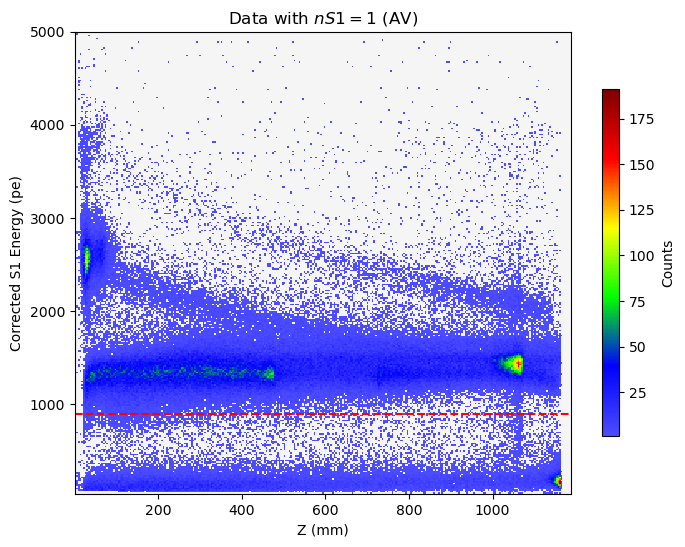

In [72]:
# Global
n_bins = 300
E1_max = 5e3

# Limit line parameters: from selecting_criteria.ipynb
m = 0.17
b = -55

# Masked dataframe
# mask_df = Data_df.copy()
mask_df = Data_df[(Data_df['nS1'] == 1)]                          # Only one S1
# mask_df = mask_df[mask_df['S1h'] >= m * mask_df['S1e'] + b]

# Variables
E1 = mask_df['S1e']
Z  = mask_df['Z']

# Masking
AV_mask = (Z >= 0) & (Z < 0.98*pt.N100_hei)
E1_masked = E1[AV_mask]
Z_masked  = Z[AV_mask]

# Binning
E1_bins = np.linspace(E1.min(), E1_max, n_bins)
Z_bins  = np.linspace(Z.min(), pt.N100_hei, n_bins)

# 2D histogram: normalized by corrected DAQ data taking time
S1e_DT_map, ex, ey = np.histogram2d(Z_masked, E1_masked, bins=[Z_bins, E1_bins])
S1e_DT_map         = np.ma.masked_where(S1e_DT_map==0, S1e_DT_map)     # Zero values masked
# S1h_S1e_map         = np.clip(S1h_S1e_map, 0, 0.8e-3)                     # Clipped values in colorbar

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.pcolormesh(ex, ey, S1e_DT_map.T, cmap=pt.custom_hsv, shading='auto')
plt.plot(Z_bins, ff.linear_func(Z_bins, 0, 900), c='red', ls='--', lw=1.5)       # Limit line

# ----- Styling ----- #
cbar = plt.colorbar(label='Counts', shrink=0.75)
# cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('Z (mm)')
plt.ylabel('Corrected S1 Energy (pe)')
# plt.ylim(0, 3e3)
plt.title(r'Data with $nS1 = 1$ (AV)')

plt.gca().set_facecolor("whitesmoke")
plt.show() 

## Execution

In [10]:
# Total effiency counters
Total_nS1_one = 0
Total_E_tresh = 0

for data, tag in zip([Data_df, MC_df], ["Data", "MC"]):

    print(f"\n--- Processing {tag} with {data.global_event.nunique()} Events---\n")

    # ----- nS1 = 1 ----- #
    print("For nS1 = 1:")
    # Only for MC
    if tag == "MC":
        
        # Select only the events with one S1
        data = data[data['nS1'] == 1].copy()
        print(f"  post  → {data.global_event.nunique()} events\n")

    else:
        print("  Data already have nS1 = 1!\n")

    # ----- E >= 0.5 MeV  ----- #
    print("For E >= 0.5 MeV:")

    # Apply energy treshold
    data = data[data['Ec'] >= 0.5].copy()
    print(f"  post  → {data.global_event.nunique()} events\n")

    # ----- Store the DataFrame ----- #
    if tag == "Data":
        selected_data_df['Electron']['All'] = data.copy()
    elif tag == "MC":
        selected_mc_df['Electron']['All']   = data.copy()


--- Processing Data with 53285 Events---

For nS1 = 1:
  Data already have nS1 = 1!

For E >= 0.5 MeV:
  post  → 35497 events


--- Processing MC with 2980175 Events---

For nS1 = 1:
  post  → 2971490 events

For E >= 0.5 MeV:
  post  → 2062653 events



# Selection

## $nS2 = 1$

In [11]:
for data, tag in zip([selected_data_df['Electron']['All'], selected_mc_df['Electron']['All']], ["Data", "MC"]):

    print(f"\n--- Processing {tag} with {data.global_event.nunique()} Events ---\n")

    # ----- nS2 = 1 ----- #
    print("For nS2 = 1:")

    # Select only the events with one S2
    data = data[data['nS2'] == 1].copy()
    print(f"  post  → {data.global_event.nunique()} events\n")

    # ----- Store the DataFrame ----- #
    if tag == "Data":
        selected_data_df['Electron']['All'] = data.copy()
    elif tag == "MC":
        selected_mc_df['Electron']['All']   = data.copy()


--- Processing Data with 35497 Events ---

For nS2 = 1:
  post  → 29116 events


--- Processing MC with 2062653 Events ---

For nS2 = 1:
  post  → 1610767 events



## Detector Regions

In [12]:
# Containment limits definition 
Z_low = 40          # in [mm]
Z_up  = 1147        # in [mm]
R_up  = 451.65      # in [mm]

In [13]:
for data, tag in zip([selected_data_df['Electron']['All'], selected_mc_df['Electron']['All']], ["Data", "MC"]):

    print(f"\n--- Processing {tag} with {data.global_event.nunique()} Events ---\n")

    evts_All = data.global_event.nunique()      # Total number of events before selection

    # ----- Store the DataFrame ----- #
    if tag == "Data":

        selected_data_df['Electron']['Fiducial'] = data[(data.Z_min >= Z_low) & (data.Z_max <= Z_up) & (data.R_max <= R_up)].copy()
        fiducial_evts = selected_data_df['Electron']['Fiducial'].global_event.nunique()
        print(f"Fiducial: {fiducial_evts} events ({fiducial_evts/evts_All:.2%})")

        selected_data_df['Electron']['Tube'] = data[(data.Z_min >= Z_low) & (data.Z_max <= Z_up) & (data.R_max > R_up)].copy()
        tube_evts = selected_data_df['Electron']['Tube'].global_event.nunique()
        print(f"Tube: {tube_evts} events ({tube_evts/evts_All:.2%})")

        selected_data_df['Electron']['Anode'] = data[data.Z_min < Z_low].copy()
        anode_evts = selected_data_df['Electron']['Anode'].global_event.nunique()
        print(f"Anode: {anode_evts} events ({anode_evts/evts_All:.2%})")

        selected_data_df['Electron']['Cathode'] = data[data.Z_max > Z_up].copy()
        cathode_evts = selected_data_df['Electron']['Cathode'].global_event.nunique()
        print(f"Cathode: {cathode_evts} events ({cathode_evts/evts_All:.2%})")

    elif tag == "MC":

        selected_mc_df['Electron']['Fiducial'] = data[(data.Z_min >= Z_low) & (data.Z_max <= Z_up) & (data.R_max <= R_up)].copy()
        fiducial_evts = selected_mc_df['Electron']['Fiducial'].global_event.nunique()
        print(f"Fiducial: {fiducial_evts} events ({fiducial_evts/evts_All:.2%})")

        selected_mc_df['Electron']['Tube'] = data[(data.Z_min >= Z_low) & (data.Z_max <= Z_up) & (data.R_max > R_up)].copy()
        tube_evts = selected_mc_df['Electron']['Tube'].global_event.nunique()
        print(f"Tube: {tube_evts} events ({tube_evts/evts_All:.2%})")

        selected_mc_df['Electron']['Anode'] = data[data.Z_min < Z_low].copy()
        anode_evts = selected_mc_df['Electron']['Anode'].global_event.nunique()
        print(f"Anode: {anode_evts} events ({anode_evts/evts_All:.2%})")

        selected_mc_df['Electron']['Cathode'] = data[data.Z_max > Z_up].copy()
        cathode_evts = selected_mc_df['Electron']['Cathode'].global_event.nunique()
        print(f"Cathode: {cathode_evts} events ({cathode_evts/evts_All:.2%})")


--- Processing Data with 29116 Events ---

Fiducial: 5345 events (18.36%)
Tube: 9623 events (33.05%)
Anode: 719 events (2.47%)
Cathode: 13437 events (46.15%)

--- Processing MC with 1610767 Events ---

Fiducial: 674052 events (41.85%)
Tube: 643967 events (39.98%)
Anode: 51808 events (3.22%)
Cathode: 240940 events (14.96%)


# Comparative Plots

## Fiducial Volume

### Z Position

Data fiducial rate: 0.004333 ± 0.000059 Hz
MC fiducial rate: 0.002137 ± 0.000003 Hz


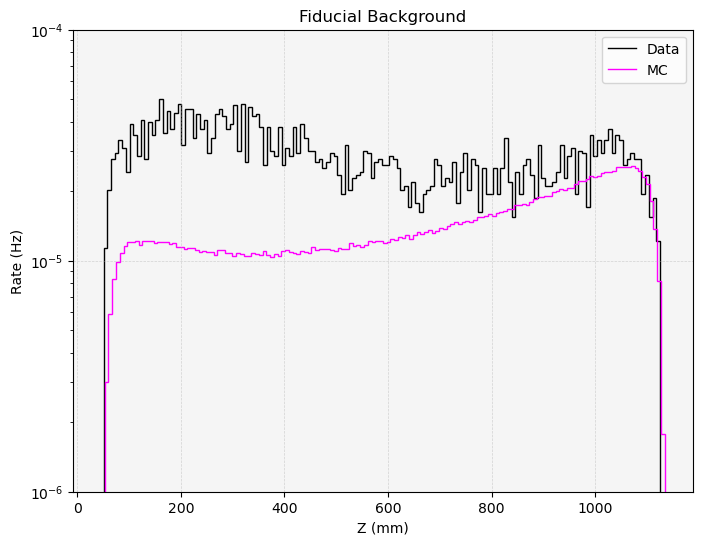

In [36]:
# Global
n_bins = 150

plt.figure(figsize=(8, 6))

color_index = 0

for info, tag in zip([selected_data_df, selected_mc_df], ["Data", "MC"]):

    # Run time 
    Run_time = info['Run_time']

    # Data
    data = info['Electron']['Fiducial']

    # Variables
    Z = data['Z']

    # Histogram: normalized by corrected DAQ data taking time
    Z_counts, Z_edges = np.histogram(Z, bins=n_bins)
    Z_rate = Z_counts / Run_time

    # Statistical error on the rate
    Z_rate_error = np.sqrt(Z_counts) / Run_time

    # Total rate and error
    total_rate = Z_rate.sum()
    total_rate_error = np.sqrt((Z_rate_error**2).sum())
    
    # Print total rate with error
    print(f"{tag} fiducial rate: {total_rate:.6f} ± {total_rate_error:.6f} Hz")

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, label=f'{tag}', 
                fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 6

# plt.axvline(x=pt.N100_hei, c='grey', ls='--', lw=1.0)        # Longitudinal limit

# ----- Styling ----- #
plt.xlabel('Z (mm)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-6, 1e-4)
plt.legend(loc='best', fontsize=10)
plt.title('Fiducial Background')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

### Energy

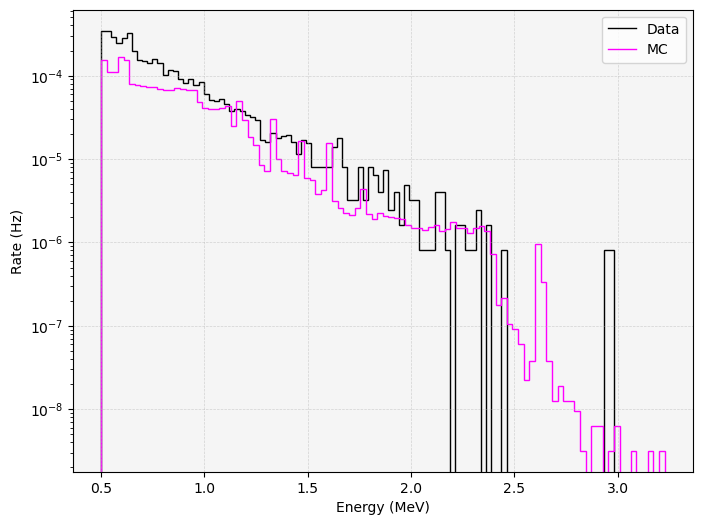

In [106]:
# Global
n_bins = 100
plt.figure(figsize=(8, 6))

color_index = 0

for info, tag in zip([selected_data_df, selected_mc_df], ["Data", "MC"]):

    # 
    Run_time = info['Run_time']
    data     = info['Electron']['Fiducial']

    # Variables
    E = data['Ec']

    # Histogram: normalized by corrected DAQ data taking time
    E_counts, E_edges = np.histogram(E, bins=n_bins)
    E_rate = E_counts / Run_time

    # Rate
    # print(f"\n{tag} - E Fiducial Rate: {E_rate.sum()} Hz")

    # ----- Plotting ----- #
    plt.stairs(E_rate, E_edges, label=f'{tag}', 
                fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 6

# plt.axvline(x=2.6, c='grey', ls='--', lw=1.0)        # Longitudinal limit

# ----- Styling ----- #
plt.xlabel('Energy (MeV)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
# plt.title(f'Hit-level: {particle}s')
plt.legend(loc='best', fontsize=10)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

# Hotspot Searches

## Fiducial Volume

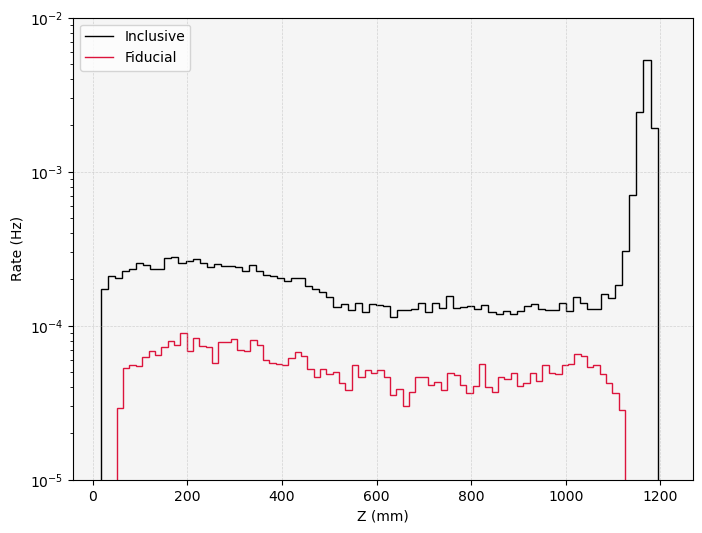

In [ ]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Fiducial']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Fiducial"]):

    # Variables
    Z = df['Z']

    # Histogram: normalized by corrected DAQ data taking time
    Z_counts, Z_edges = np.histogram(Z, bins=n_bins)
    Z_rate = Z_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 1

# plt.axvline(x=pt.N100_hei, c='grey', ls='--', lw=1.0)        # Longitudinal limit

# ----- Styling ----- #
plt.xlabel('Z (mm)')
# plt.xlim(0, pt.N100_hei)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-5, 1e-2)
plt.legend(loc='upper left', fontsize=10)
# plt.title('Fiducial Background')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

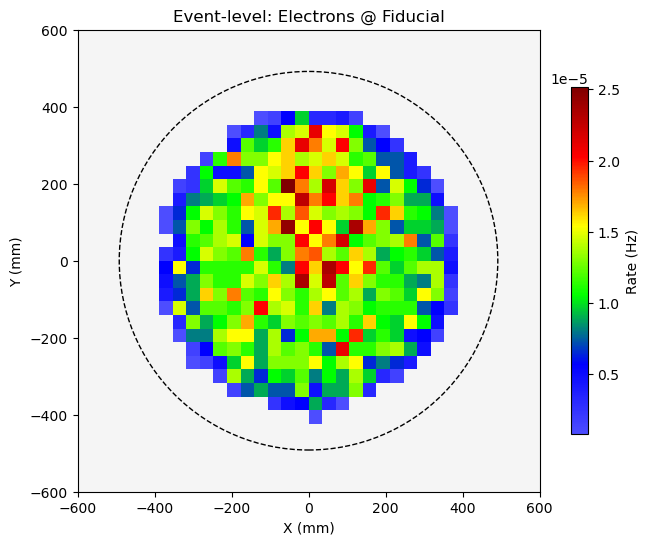

In [61]:
# Global
n_bins = 35

#
Run_time = selected_data_df['Run_time']
# Data
data = selected_data_df['Electron']['Fiducial']

# Variables
X = data['X']
Y = data['Y']

# 2D histogram: normalized by corrected DAQ data taking time
XY_hit_map, ex, ey = pt.mapping(X, Y, xy_bins=n_bins, pos=True)
XY_rate            = XY_hit_map / Run_time                          # Normalized to rate      
XY_rate            = np.ma.masked_where(XY_rate == 0, XY_rate)      # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(ex, ey, XY_rate.T, cmap=pt.custom_hsv, shading='auto')
cbar = plt.colorbar(im, label='Rate (Hz)', shrink=0.75)
cbar.formatter.set_powerlimits((-3, 3))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title(f'Event-level: Electrons @ Fiducial')

plt.gca().add_patch(pt.plot_circle(pt.N100_rad))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor("whitesmoke")
plt.show()

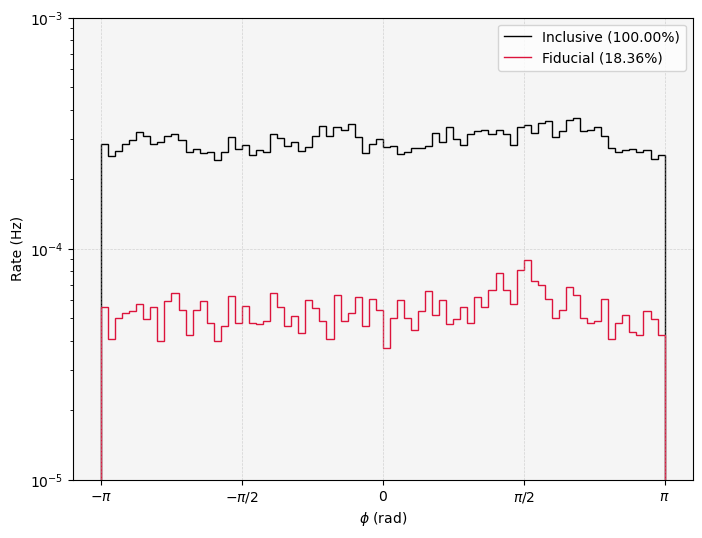

In [68]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Fiducial']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Fiducial"]):

    # Variables
    X = df['X']
    Y = df['Y']
    phi = np.arctan2(Y, X)

    # Histogram: normalized by corrected DAQ data taking time
    phi_counts, phi_edges = np.histogram(phi, bins=n_bins)
    phi_rate = phi_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(phi_rate, phi_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 1

# ----- Styling ----- #
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-5, 1e-3)
plt.legend(loc='best', fontsize=10)

# Set x-ticks as multiples of π
ticks = np.arange(-np.pi, np.pi + 0.1, np.pi / 2)
tick_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
plt.xticks(ticks, tick_labels)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show() 

## Light Tube

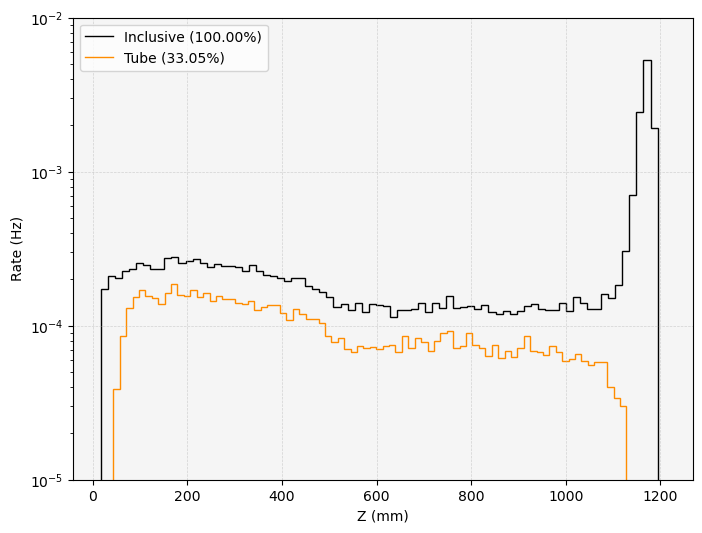

In [70]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Tube']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Tube"]):

    # Variables
    Z = df['Z']

    # Histogram: normalized by corrected DAQ data taking time
    Z_counts, Z_edges = np.histogram(Z, bins=n_bins)
    Z_rate = Z_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 2

# plt.axvline(x=pt.N100_hei, c='grey', ls='--', lw=1.0)        # Longitudinal limit

# ----- Styling ----- #
plt.xlabel('Z (mm)')
# plt.xlim(0, pt.N100_hei)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-5, 1e-2)
plt.legend(loc='upper left', fontsize=10)
# plt.title('Fiducial Background')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

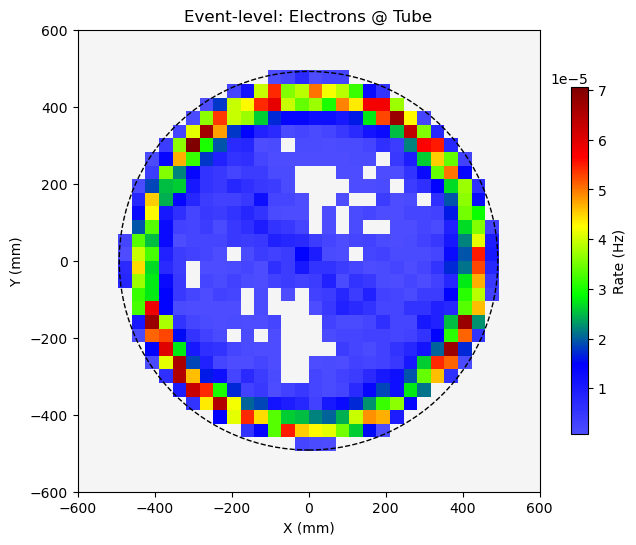

In [71]:
# Global
n_bins = 35

#
Run_time = selected_data_df['Run_time']
# Data
data = selected_data_df['Electron']['Tube']

# Variables
X = data['X']
Y = data['Y']

# 2D histogram: normalized by corrected DAQ data taking time
XY_hit_map, ex, ey = pt.mapping(X, Y, xy_bins=n_bins, pos=True)
XY_rate            = XY_hit_map / Run_time                          # Normalized to rate      
XY_rate            = np.ma.masked_where(XY_rate == 0, XY_rate)      # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(ex, ey, XY_rate.T, cmap=pt.custom_hsv, shading='auto')
cbar = plt.colorbar(im, label='Rate (Hz)', shrink=0.75)
cbar.formatter.set_powerlimits((-3, 3))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title(f'Event-level: Electrons @ Tube')

plt.gca().add_patch(pt.plot_circle(pt.N100_rad))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor("whitesmoke")
plt.show()

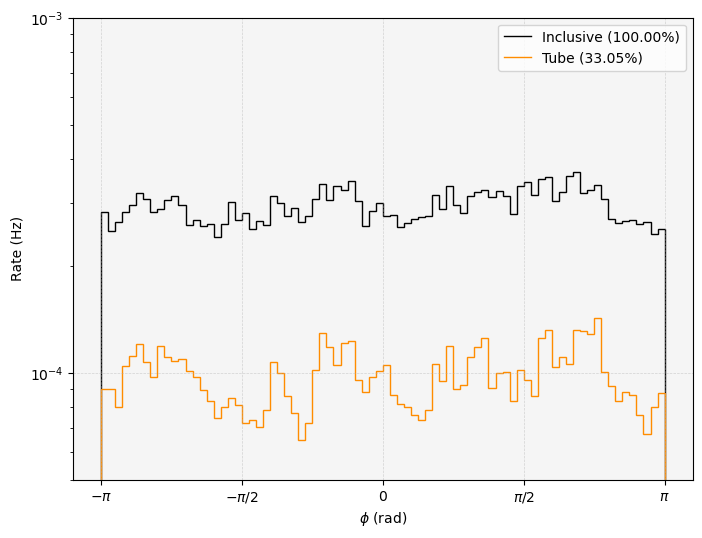

In [76]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Tube']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Tube"]):

    # Variables
    X = df['X']
    Y = df['Y']
    phi = np.arctan2(Y, X)

    # Histogram: normalized by corrected DAQ data taking time
    phi_counts, phi_edges = np.histogram(phi, bins=n_bins)
    phi_rate = phi_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(phi_rate, phi_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 2

# ----- Styling ----- #
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(5e-5, 1e-3)
plt.legend(loc='best', fontsize=10)

# Set x-ticks as multiples of π
ticks = np.arange(-np.pi, np.pi + 0.1, np.pi / 2)
tick_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
plt.xticks(ticks, tick_labels)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show() 

## Cathode

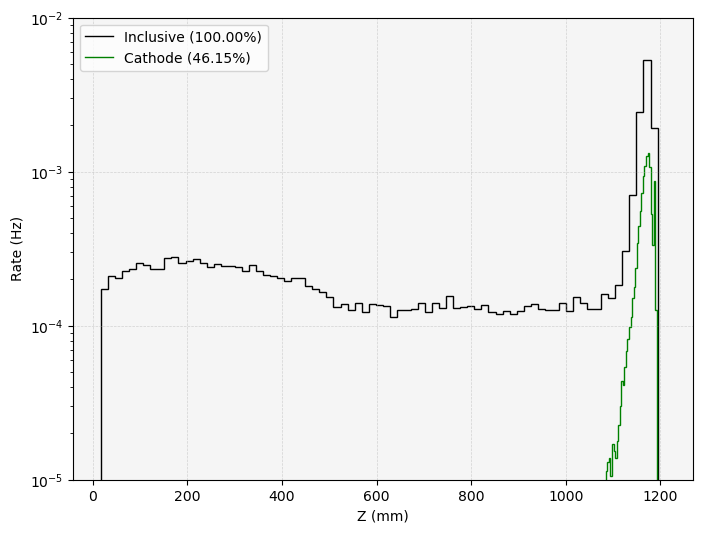

In [78]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Cathode']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Cathode"]):

    # Variables
    Z = df['Z']

    # Histogram: normalized by corrected DAQ data taking time
    Z_counts, Z_edges = np.histogram(Z, bins=n_bins)
    Z_rate = Z_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 4

# plt.axvline(x=pt.N100_hei, c='grey', ls='--', lw=1.0)        # Longitudinal limit

# ----- Styling ----- #
plt.xlabel('Z (mm)')
# plt.xlim(0, pt.N100_hei)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-5, 1e-2)
plt.legend(loc='upper left', fontsize=10)
# plt.title('Fiducial Background')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

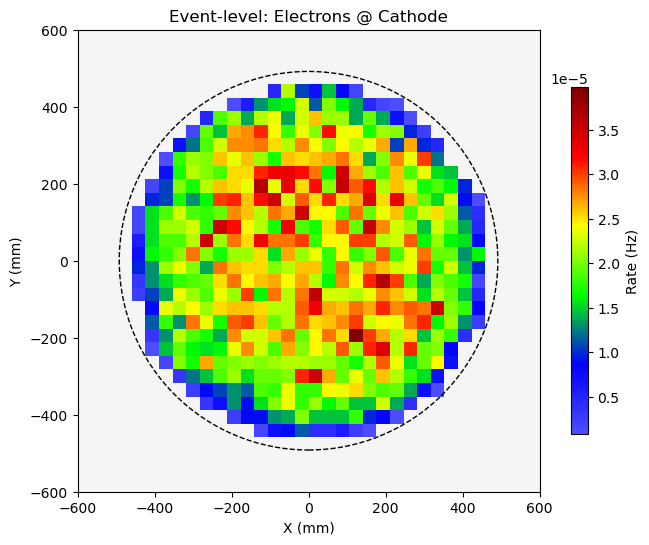

In [79]:
# Global
n_bins = 35

#
Run_time = selected_data_df['Run_time']
# Data
data = selected_data_df['Electron']['Cathode']

# Variables
X = data['X']
Y = data['Y']

# 2D histogram: normalized by corrected DAQ data taking time
XY_hit_map, ex, ey = pt.mapping(X, Y, xy_bins=n_bins, pos=True)
XY_rate            = XY_hit_map / Run_time                          # Normalized to rate      
XY_rate            = np.ma.masked_where(XY_rate == 0, XY_rate)      # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(ex, ey, XY_rate.T, cmap=pt.custom_hsv, shading='auto')
cbar = plt.colorbar(im, label='Rate (Hz)', shrink=0.75)
cbar.formatter.set_powerlimits((-3, 3))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title(f'Event-level: Electrons @ Cathode')

plt.gca().add_patch(pt.plot_circle(pt.N100_rad))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor("whitesmoke")
plt.show()

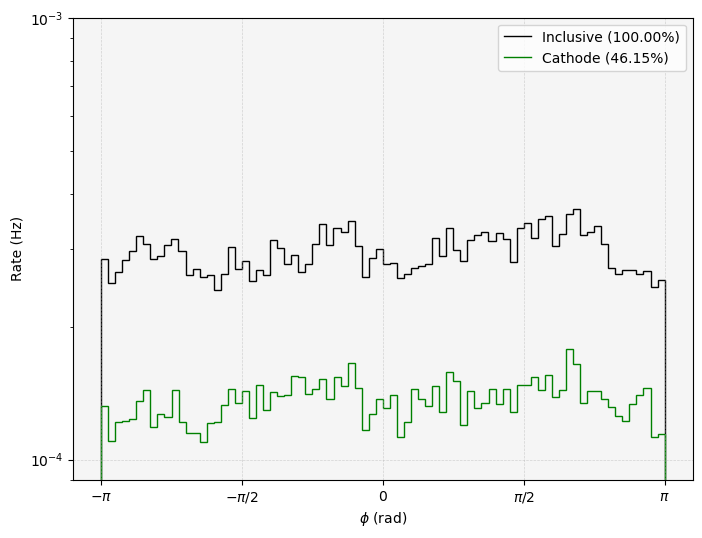

In [84]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Cathode']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Cathode"]):

    # Variables
    X = df['X']
    Y = df['Y']
    phi = np.arctan2(Y, X)

    # Histogram: normalized by corrected DAQ data taking time
    phi_counts, phi_edges = np.histogram(phi, bins=n_bins)
    phi_rate = phi_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(phi_rate, phi_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 4

# ----- Styling ----- #
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(9e-5, 1e-3)
plt.legend(loc='best', fontsize=10)

# Set x-ticks as multiples of π
ticks = np.arange(-np.pi, np.pi + 0.1, np.pi / 2)
tick_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
plt.xticks(ticks, tick_labels)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show() 

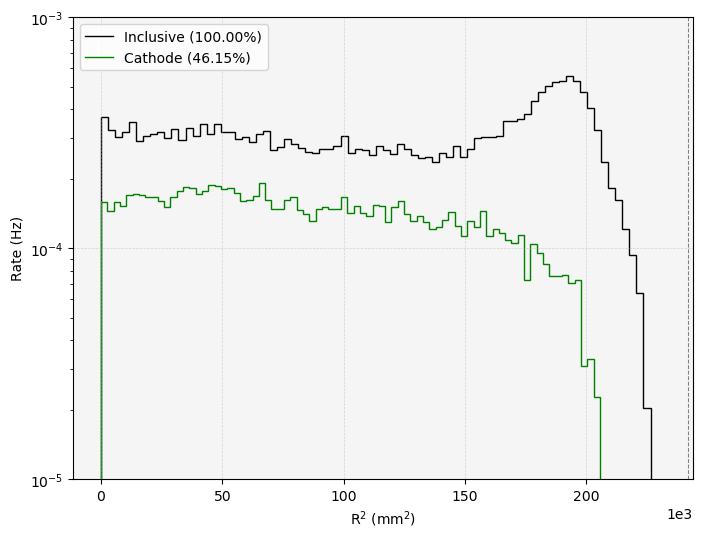

In [102]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Cathode']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Cathode"]):

    # Variables
    R2 = df['X']**2 + df['Y']**2

    # Histogram: normalized by corrected DAQ data taking time
    R2_counts, R2_edges = np.histogram(R2, bins=n_bins)
    R2_rate = R2_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(R2_rate, R2_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 4

# ----- Styling ----- #
plt.xlabel(r'R$^{2}$ (mm$^{2}$)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-5, 1e-3)
plt.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
plt.legend(loc='upper left', fontsize=10)

# Radial limit
plt.axvline(x=pt.N100_rad**2, c='grey', ls='--', lw=0.75)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## Anode

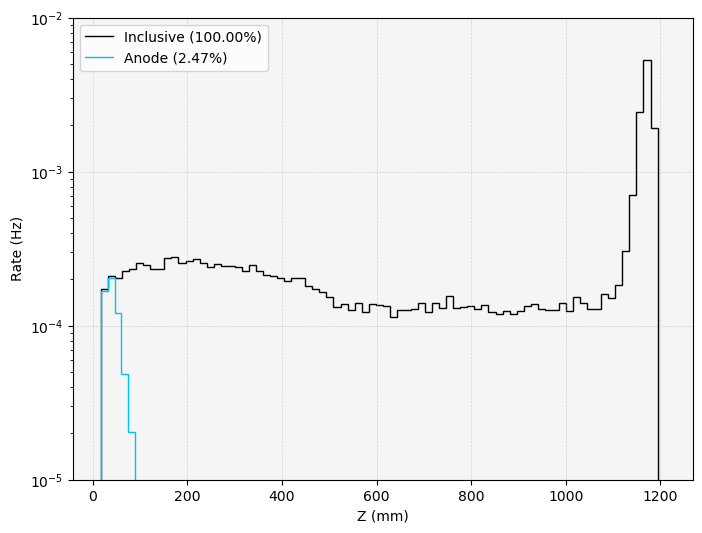

In [90]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Anode']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Anode"]):

    # Variables
    Z = df['Z']

    # Histogram: normalized by corrected DAQ data taking time
    Z_counts, Z_edges = np.histogram(Z, bins=n_bins)
    Z_rate = Z_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 3

# plt.axvline(x=pt.N100_hei, c='grey', ls='--', lw=1.0)        # Longitudinal limit

# ----- Styling ----- #
plt.xlabel('Z (mm)')
# plt.xlim(0, pt.N100_hei)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-5, 1e-2)
plt.legend(loc='upper left', fontsize=10)
# plt.title('Fiducial Background')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

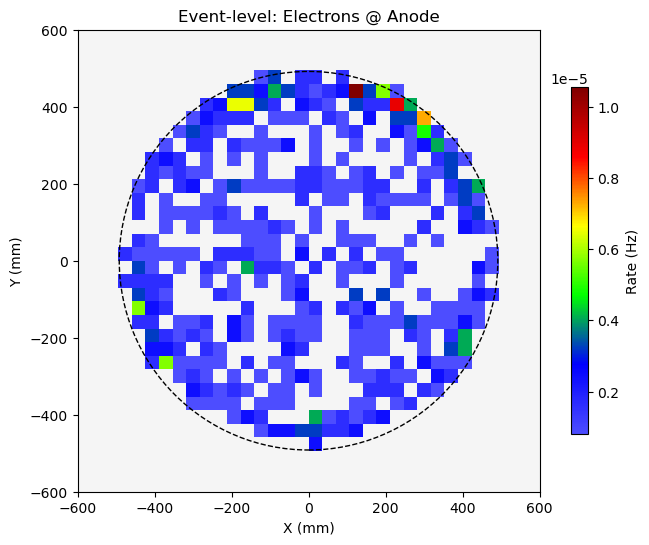

In [91]:
# Global
n_bins = 35

#
Run_time = selected_data_df['Run_time']
# Data
data = selected_data_df['Electron']['Anode']

# Variables
X = data['X']
Y = data['Y']

# 2D histogram: normalized by corrected DAQ data taking time
XY_hit_map, ex, ey = pt.mapping(X, Y, xy_bins=n_bins, pos=True)
XY_rate            = XY_hit_map / Run_time                          # Normalized to rate      
XY_rate            = np.ma.masked_where(XY_rate == 0, XY_rate)      # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(ex, ey, XY_rate.T, cmap=pt.custom_hsv, shading='auto')
cbar = plt.colorbar(im, label='Rate (Hz)', shrink=0.75)
cbar.formatter.set_powerlimits((-3, 3))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title(f'Event-level: Electrons @ Anode')

plt.gca().add_patch(pt.plot_circle(pt.N100_rad))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor("whitesmoke")
plt.show()

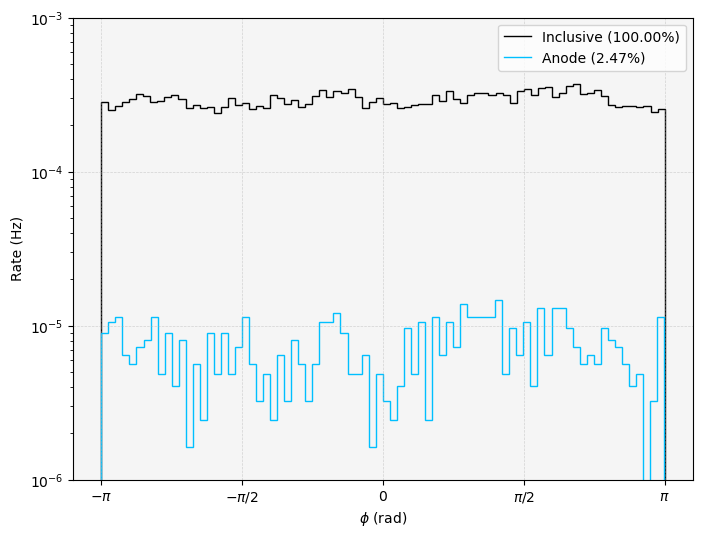

In [94]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Anode']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Anode"]):

    # Variables
    X = df['X']
    Y = df['Y']
    phi = np.arctan2(Y, X)

    # Histogram: normalized by corrected DAQ data taking time
    phi_counts, phi_edges = np.histogram(phi, bins=n_bins)
    phi_rate = phi_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(phi_rate, phi_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 3

# ----- Styling ----- #
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-6, 1e-3)
plt.legend(loc='best', fontsize=10)

# Set x-ticks as multiples of π
ticks = np.arange(-np.pi, np.pi + 0.1, np.pi / 2)
tick_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
plt.xticks(ticks, tick_labels)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show() 

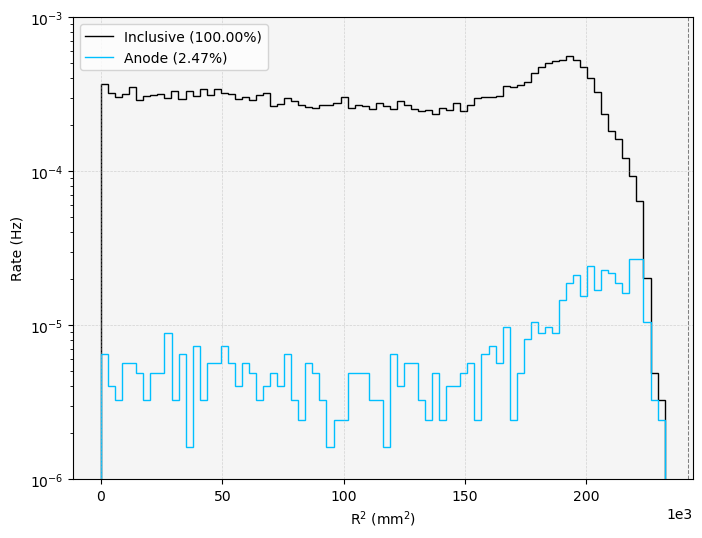

In [101]:
# Global
n_bins = 80

plt.figure(figsize=(8, 6))

color_index = 0

#
Run_time = selected_data_df['Run_time']
# Data
data_all = selected_data_df['Electron']['All']
data_vol = selected_data_df['Electron']['Anode']

for df, tag in zip([data_all, data_vol], ["Inclusive", "Anode"]):

    # Variables
    R2 = df['X']**2 + df['Y']**2

    # Histogram: normalized by corrected DAQ data taking time
    R2_counts, R2_edges = np.histogram(R2, bins=n_bins)
    R2_rate = R2_counts / Run_time

    # Calculate percentage of fiducial events with respect to all events
    percentage = (df.global_event.nunique() / data_all.global_event.nunique()) * 100
    label = f'{tag} ({percentage:.2f}%)'

    # ----- Plotting ----- #
    plt.stairs(R2_rate, R2_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[color_index % len(pt.hist_colors)])
    
    color_index += 3

# ----- Styling ----- #
plt.xlabel(r'R$^{2}$ (mm$^{2}$)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.ylim(1e-6, 1e-3)
plt.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
plt.legend(loc='upper left', fontsize=10)

# Radial limit
plt.axvline(x=pt.N100_rad**2, c='grey', ls='--', lw=0.75)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()